In [1]:
%ls

6lzg_Repair.pdb                molecules/
analyze_new_data.ipynb         new_train_data/
analyz_foldx_eval_ibex.ipynb   old_train_data/
analyz_foldx_train_ibex.ipynb  prepare foldx input.ipynb
download_model/                rotabase.txt
figures/                       run_foldx_eval_ibex.ipynb
foldx_20231231*                run_foldx_top_ibex.ipynb
foldx_input/                   run_foldx_train_ibex.ipynb
foldx_output/                  temp/
gen_data/


In [2]:
import os
import io
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

### current conclusion

1. ddG (congen2 6+6 layer) -1.0, -1.5, -2.0, 3种perturb方案差别不大，结果几乎一样，它们三个的top100集合有90%的序列相同，它们的min都大于-8
2. ddG (congen5 6+6 layer) -1.0 + cycle perturbation 差别很大，感觉性能会高一些的，尽管均值差不多，但是方差大，它的top100和前三个集合没有序列相同，最小值达到了-10
3. ddG (congen2 6+6 layer) -1.0 + high generation temperature 差别很大，整体性能比1.中的三个好，min值有-8，mean值也更小-4.77，top100仅有10%的序列相同
4. ddG (congen4 6+6 layer) -1.0 + co-optimization ddG top100，整体性能次最差，mean -3.43，生成的top100与1. 2. 3. 中的都不重合，最diverse，应该说受solubility的影响
5. ddG (congen4 6+6 layer) -1.0 + co-optimization ddG_solubility_avg top100，整体性能最差，mean -2.28，生成的top100与1. 2. 3. 中的都不重合，与4.有84%重序列相同
6. ddG -2.0 两个版本的对比说明foldx的评估结果很相似，几乎一样，说明foldx预测结果其实比较稳定，方差比想象中要小

### new conclusion

1. ddG (congen7 24+24 layer) -1.1, 基本上复现了原论文的结果，可视化的分布图基本上重合了，指标上的数值略差估计是因为调参等原因
2. ddG (congen8 6+6 layer) -1.1, congen7的mini版，主要是因为时间和资源有限，想看看能达到什么样的效果，基本上比论文结果差一截，看来层数还是很重要
3. 期间生成序列时发现对于新的dataset而言，lm loss感觉训练得更好了，生成的序列更加保守了
4. ddG (congen8 6+6 layer) -1.1, -2.2, -3.3, 之间的对比说明扰动的幅度好像是对性能有影响的，-2.2 mean最好，但是影响的程度不大明显
5. ddG (congen8 6+6 layer) -1.1, -2.2, -3.3, -4.4, -8.0, -12.0, -16.0, -20.0 之间的对比说明的确是幅度越大性能越好
- 以上结果均基于temperature_init=2.0, temperature_multiple=1.003的设定而生成的序列

1. 考虑使用2.0, 3.0, 4.0, 5.0的temperature生成序列，high temperature的结果更差，估计使用1.0是最好的，但是很慢，这个balance需要权衡

## setting

In [3]:
foldx_dir = '/home/hew/python/genhance/foldx/'
foldx_exe_path = foldx_dir + 'foldx_20231231'
numberOfRuns = 5
foldx_command = '-c BuildModel --numberOfRuns {} --pdb=6lzg_Repair.pdb --mutant-file={} --output-dir={}'
submit_script = 'sbatch --job-name={} --output={}%j.out --error={}%j.err --time=10:00 {}'
eval_input_dir = foldx_dir + 'foldx_input/'
eval_output_dir = foldx_dir + 'foldx_output/'
eval_output_dir

'/home/hew/python/genhance/foldx/foldx_output/'

In [4]:
input_list = [d for d in os.listdir(eval_output_dir) if os.path.isdir(os.path.join(eval_output_dir, d))]
input_list

['congen2_260000_[-1.0]',
 'congen5_260000_[-1.0]_copy',
 'congen2_260000_[-2.0]',
 'congen2_260000_[-1.5]',
 'congen5_260000_[-1.0]',
 'congen4_250000_[-1.0]',
 'congen2_250000_[-1.0]',
 '.ipynb_checkpoints',
 'congen2_260000_[-2.0]_copy',
 'congen4_250000_[-1.0]_avg',
 'congen8_new_ddG_260000_[-2.2]_[5.0]',
 'congen8_new_ddG_260000_[-8.0]_[2.0]',
 'congen8_new_ddG_260000_[-2.2]_[6.0]',
 'congen8_new_ddG_260000_[-4.4]_[2.0]',
 'congen8_new_ddG_260000_[-2.2]_[2.0]',
 'congen8_new_ddG_260000_[-12.0]_[2.0]',
 'congen8_new_ddG_260000_[-1.1]_[2.0]',
 'congen7_new_ddG_260000_[-1.1]_[2.0]',
 'congen8_new_ddG_260000_[-2.2]_[4.0]',
 'congen8_new_ddG_260000_[-3.3]_[2.0]',
 'congen8_new_ddG_260000_[-2.2]_[3.0]',
 'congen8_new_ddG_260000_[-16.0]_[2.0]',
 'congen8_new_ddG_260000_[-20.0]_[2.0]',
 'congen8_new_ddG_260000_[-40.0]_[2.0]',
 'congen8_new_ddG_260000_[-40.0]_[2.0]_top1000',
 'congen8_new_ddG_260000_[-40.0]_[2.0]_Emin',
 'congen8_new_ddG_260000_[-30.0]_[2.0]',
 'congen8_new_ddG_260000_[-40

In [16]:
input_index = -8
output_dir = f'{eval_output_dir}/{input_list[input_index]}/'
output_dir

'/home/hew/python/genhance/foldx/foldx_output//congen8_new_ddG_260000_[-40.0]_[1.0]_top1000/'

## load train data

In [17]:
# train_data_path = foldx_dir + 'old_train_data/train_tophalf_ddG_solubility.pkl'
train_data_path = foldx_dir + 'new_train_data/train_new_all_data.pkl'
train_data = open(train_data_path, 'rb')
train_data = pickle.load(train_data)
train_data_ddG = train_data.ddG

# np.min(train_data_ddG) = -8.44902，属于离群点

np.min(train_data_ddG), np.max(train_data_ddG), np.mean(train_data_ddG), min(train_data.sort_values(by='ddG', ascending=True)[1:].ddG)

(-8.44902, 60.6313, 5.958470991966364, -6.15326)

In [18]:
train_data.sort_values(by='ddG', ascending=True)

,PDB,Chain,Start_index,WT_seq,MT_seq,solubility,ddG,ddG_std,ddG_rank,solubility_rank,avg_rank
166709,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKYFLLKFNHEAEDLFYQSSLAKWNYNTNITEENVQYMNN...,0.624,-8.44902,0.526837,1.0,247826.0,123913.50
218948,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SDIEESAKTFLDKFMLEAEDLFYQSSLAVWNYNTNITEENVQNMNN...,0.764,-6.15326,0.068304,2.0,114868.5,57435.25
117039,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.713,-6.02438,0.134153,3.0,200682.0,100342.50
122232,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,ITIELQAKYFLDKFNHEAEDLFYQLSLASWNYNTNITEENVQNMNN...,0.713,-5.97785,0.682113,4.0,200682.0,100343.00
105382,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKQFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNF...,0.711,-5.84588,0.110335,5.0,220699.5,110352.25
...,...,...,...,...,...,...,...,...,...,...,...
53007,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIHEQWKTFLDKFNHYAEDLFYFSSLASWHYNTNITEENVQNMNI...,0.633,55.65400,10.946300,249996.0,246681.5,248338.75
171213,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIFEQWKTFLDKFVHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.713,56.51240,1.016230,249997.0,200682.0,225339.50
160333,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQYKTFLDKFNHHYVDLFYQSSLASWNYNTNITEENVQNMNN...,0.674,56.99980,1.898220,249998.0,238200.0,244099.00
180894,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQWKTFLDKFNHEPEDLFYQSSLSSWNGNTNITEENVQNMNN...,0.795,59.24410,4.604260,249999.0,18749.5,134374.25


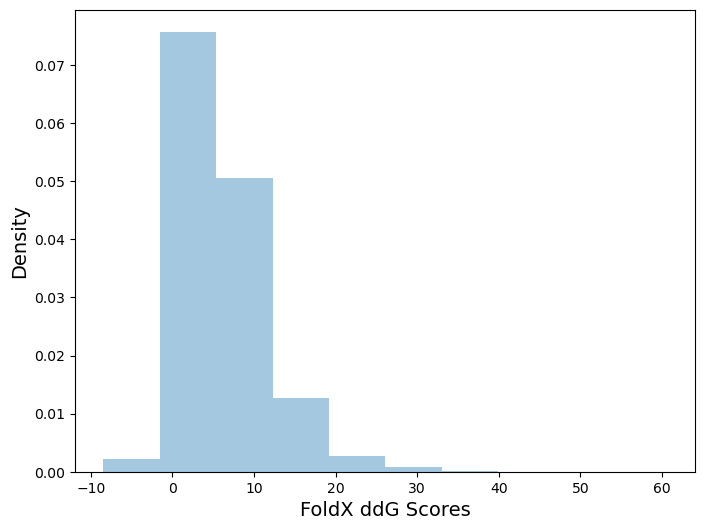

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(train_data.ddG, density=True, alpha=0.4)
plt.xlabel('FoldX ddG Scores', size=14)
plt.ylabel('Density', size=14)
plt.savefig('./figures/train_ddG_dist.png', bbox_inches='tight')
plt.savefig('./figures/train_ddG_dist.pdf', bbox_inches='tight')

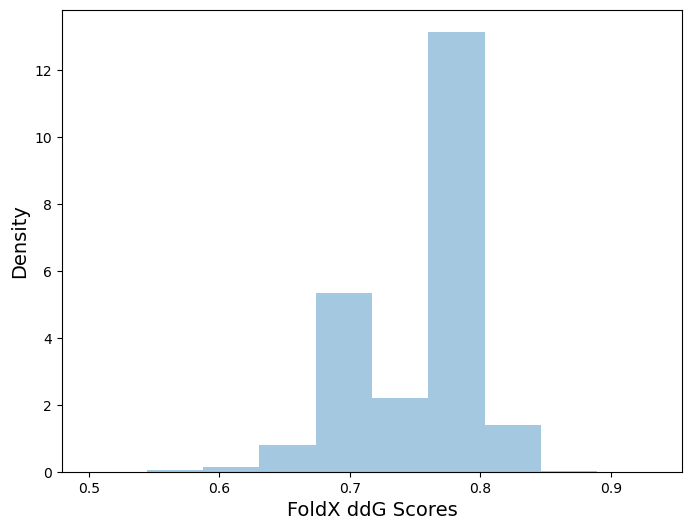

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(train_data.solubility, density=True, alpha=0.4)
plt.xlabel('FoldX ddG Scores', size=14)
plt.ylabel('Density', size=14)
plt.savefig('./figures/train_solubility_dist.png', bbox_inches='tight')
plt.savefig('./figures/train_solubility_dist.pdf', bbox_inches='tight')

## merge multiple results

In [21]:
def get_job_result(job_dir):
    res_file = job_dir + 'Average_6lzg_Repair.fxout'
    if not os.path.exists(res_file):
        print('unfinished job_dir:', job_dir)
        return None, None, None, 1
    with open(res_file, 'r') as file:
        job_result = file.read()
    df_string = '\n'.join(job_result.split('\n')[8:])
    result_df = pd.read_csv(io.StringIO(df_string), sep='\t')
    avg_ddG = result_df['total energy'].to_list()[0]
    std_ddG = result_df['SD'].to_list()[0]
    
    seq_file = job_dir + 'sequence.txt'
    with open(seq_file, 'r') as file:
        sequence = file.read().split('\n')
    assert len(sequence) == 1
    return sequence[0], avg_ddG, std_ddG, 0

def merge_results(output_dir):
    unfinished_num = 0
    seq_list = []
    avg_ddG_list = []
    std_ddG_list = []
    job_list = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]
    for job_dir_i in tqdm(job_list):
        if 'job' in job_dir_i:
            job_dir_i = output_dir + job_dir_i + '/'
            sequence_i, avg_ddG_i, std_ddG_i, flag = get_job_result(job_dir_i)
            unfinished_num += flag
            seq_list.append(sequence_i)
            avg_ddG_list.append(avg_ddG_i)
            std_ddG_list.append(std_ddG_i)
        else:
            print('skip invalid job dir:', job_dir_i)
    print('unfinished_num,', 'len(seq_list),', 'len(avg_ddG_list),', 'len(std_ddG_list)')
    print('{}, {}, {}, {}'.format(unfinished_num, len(seq_list), len(avg_ddG_list), len(std_ddG_list)))
    merge_df = pd.DataFrame([seq_list, avg_ddG_list, std_ddG_list], index=['seqs', 'mean', 'std']).T
    return merge_df

In [22]:
merge_df = merge_results(output_dir)

100%|██████████| 1000/1000 [00:15<00:00, 65.13it/s]

unfinished_num, len(seq_list), len(avg_ddG_list), len(std_ddG_list)
0, 1000, 1000, 1000


In [23]:
sum(merge_df.isnull().T.any())

0

In [24]:
merge_df

,seqs,mean,std
0,STIEEMAKLFLDKFNHEAEDLFYQSLLASWNYNTNITEENMQNMNN...,-9.41572,0.214916
1,STIEEMAKTFLEKFNHEAEDLFYQSSLALWSYNTNITEENVQNMNN...,-11.7548,0.320764
2,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENMQNMNL...,-9.6076,0.296504
3,STIEEQAKTFLEKFNHEAEDLFYQSSLAMWNYNTNITEENVQNMNN...,-8.55775,0.197714
4,STIEEQAKTFLDKFNHEAEDLFYQSSLKAWNYNTNITEENVQNMNN...,-8.28695,0.032823
...,...,...,...
995,STIEEQAKTFLMKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNL...,-7.16963,0.27955
996,SNIEEMAKTFLDKFNHEAEDLFYQSLLASWNYNTNITEENVQNMNM...,-6.03996,0.548796
997,STIEEMALTFLYKFNHEAEDLFYQSMLAAWNYNTNITEENVQNMNN...,-6.09501,0.168115
998,STIEEQAKTFLDKFNHEAEDLFYQSKLASWNMNTNITEENVQNMNK...,-7.62211,0.477125


In [25]:
merge_df = merge_df.fillna(method='ffill')
merge_df = merge_df.fillna(method='bfill')
merge_df

,seqs,mean,std
0,STIEEMAKLFLDKFNHEAEDLFYQSLLASWNYNTNITEENMQNMNN...,-9.41572,0.214916
1,STIEEMAKTFLEKFNHEAEDLFYQSSLALWSYNTNITEENVQNMNN...,-11.75480,0.320764
2,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENMQNMNL...,-9.60760,0.296504
3,STIEEQAKTFLEKFNHEAEDLFYQSSLAMWNYNTNITEENVQNMNN...,-8.55775,0.197714
4,STIEEQAKTFLDKFNHEAEDLFYQSSLKAWNYNTNITEENVQNMNN...,-8.28695,0.032823
...,...,...,...
995,STIEEQAKTFLMKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNL...,-7.16963,0.279550
996,SNIEEMAKTFLDKFNHEAEDLFYQSLLASWNYNTNITEENVQNMNM...,-6.03996,0.548796
997,STIEEMALTFLYKFNHEAEDLFYQSMLAAWNYNTNITEENVQNMNN...,-6.09501,0.168115
998,STIEEQAKTFLDKFNHEAEDLFYQSKLASWNMNTNITEENVQNMNK...,-7.62211,0.477125


In [26]:
merge_df[merge_df['mean']<-8.1]

,seqs,mean,std
0,STIEEMAKLFLDKFNHEAEDLFYQSLLASWNYNTNITEENMQNMNN...,-9.41572,0.214916
1,STIEEMAKTFLEKFNHEAEDLFYQSSLALWSYNTNITEENVQNMNN...,-11.75480,0.320764
2,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENMQNMNL...,-9.60760,0.296504
3,STIEEQAKTFLEKFNHEAEDLFYQSSLAMWNYNTNITEENVQNMNN...,-8.55775,0.197714
4,STIEEQAKTFLDKFNHEAEDLFYQSSLKAWNYNTNITEENVQNMNN...,-8.28695,0.032823
...,...,...,...
962,STIEELAKTFLDKFNHEAEDLFYQSLLASWNYNTNITEENVQNMNN...,-9.46952,0.683014
968,STIEEQAKTFLDKFNHEAEDLFYQSLLASWNFNTNITEENVQNMNN...,-8.16525,0.235717
969,SSIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENIQNMNL...,-8.14112,0.358580
978,STIEEMAKMFLEKFNHMAEDLFYMSSLASWRYNTNITEENVQNMNN...,-8.42411,0.414923


In [28]:
merge_df.to_csv('./congen8_ddG_top1000_ddG_df.csv', index=False)

In [49]:
topk = 10
gen_seqs = merge_df['seqs'].tolist()[:topk]
avg_ddG_list = merge_df['mean'].tolist()
topk_avg_ddG_list = avg_ddG_list[:topk]
np.min(topk_avg_ddG_list), np.max(topk_avg_ddG_list), np.mean(topk_avg_ddG_list)

(12.9553, 26.7484, 19.91466)

In [52]:
topk = 100
gen_seqs = merge_df['seqs'].tolist()[:topk]
avg_ddG_list = merge_df['mean'].tolist()
topk_avg_ddG_list = avg_ddG_list[:topk]
np.min(topk_avg_ddG_list), np.max(topk_avg_ddG_list), np.mean(topk_avg_ddG_list)

(10.4269, 32.0102, 18.87883)

In [54]:
topk = 1000
gen_seqs = merge_df['seqs'].tolist()[:topk]
avg_ddG_list = merge_df['mean'].tolist()
topk_avg_ddG_list = avg_ddG_list[:topk]
np.min(topk_avg_ddG_list), np.max(topk_avg_ddG_list), np.mean(topk_avg_ddG_list)

(4.65126, 32.5027, 17.320007580000002)

In [55]:
# train_best_value = np.min(train_data_ddG)
train_best_value = min(train_data.sort_values(by='ddG', ascending=True)[1:].ddG)
train_mean_value = np.mean(train_data_ddG)


def Mean(topk_avg_ddG_list):
    return 'Mean: {:.2f}'.format(np.mean(topk_avg_ddG_list))

def PCI(topk_avg_ddG_list):
    num_improve = (np.array(topk_avg_ddG_list) <= train_best_value).sum()
    PCI = num_improve/len(topk_avg_ddG_list)*100
    return 'PCI: {:.1f}%'.format(PCI)

def hamming_distance(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")
    return sum(s1 != s2 for s1, s2 in zip(seq1, seq2))

def Diversity(gen_seqs):
    distances = []
    for i, seq_i in enumerate(gen_seqs):
        for j, seq_j in enumerate(gen_seqs):
            if i!=j:
                distances.append(hamming_distance(seq_i, seq_j))
    return np.mean(distances)

def worker(args):
    genseq, trainseqs = args
    mindist = np.min([hamming_distance(genseq, trainseq) for trainseq in trainseqs])
    return mindist

def Novelty(genseqs, trainseqs):
    with Pool(cpu_count()) as pool:
        avgdist = list(tqdm(pool.imap(worker, [(genseq, trainseqs) for genseq in genseqs]), total=len(genseqs)))
    return np.mean(avgdist)

train_best_value, train_mean_value

(-6.15326, 5.958470991966364)

In [56]:
'{}, {}, {}'.format(f'top-{len(topk_avg_ddG_list)}:', Mean(topk_avg_ddG_list), PCI(topk_avg_ddG_list))

'top-1000:, Mean: 17.32, PCI: 0.0%'

In [47]:
Diversity(gen_seqs)

11.56653053053053

In [48]:
Novelty(gen_seqs, train_data.MT_seq)

100%|██████████| 1000/1000 [02:39<00:00,  6.26it/s]


2.593

In [24]:
merge_df[merge_df['mean']<train_best_value]

,seqs,mean,std
21,STIEEQAKTFLDKFNHEAEDMFYQSSEASWNYNTNITEENVQNMNN...,-6.16312,0.601258
33,STIEEQAKTFLDKFNHEAEDMFYQSSIASWNYNTNITEENVQNMAN...,-6.28283,0.177620
848,STIEEQAKTFLDKFNHEAEDMFYQSSVASWNYNTNITEENVQNMNN...,-6.50735,0.319429


- ddG
- 48 layers, 2.0, -1.1:  (-10.3086, -4.30885, -6.5473921) top-100:, Mean: -6.55, PCI-Best: 59.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 48 layers, 2.0, -16.0: 
- 48 layers, 2.0, -20.0: 
----
- 12 layers, 2.0, -40.0: (-11.1180, -5.06338, -7.6230689) top-100:, Mean: -7.62, PCI-Best: 86.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -30.0: (-10.7551, -3.49273, -7.1421891) top-100:, Mean: -7.14, PCI-Best: 78.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -20.0: (-9.11782, -3.98140, -6.4333598) top-100:, Mean: -6.42, PCI-Best: 61.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -16.0: (-10.7336, -4.24514, -6.5120394) top-100:, Mean: -6.50, PCI-Best: 57.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -12.0: (-9.68992, -3.71562, -6.3086163) top-100:, Mean: -6.31, PCI-Best: 51.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -8.0:  (-9.68992, -3.71562, -6.2394065) top-100:, Mean: -6.24, PCI-Best: 51.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -4.4:  (-8.92004, -3.21804, -6.1134886) top-100:, Mean: -6.11, PCI-Best: 44.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -3.3:  (-8.92004, -3.21804, -6.0910688) top-100:, Mean: -6.09, PCI-Best: 42.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -2.2:  (-8.92004, -3.90838, -6.1798431) top-100:, Mean: -6.18, PCI-Best: 48.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 2.0, -1.1:  (-8.92004, -3.90838, -6.0117028) top-100:, Mean: -6.01, PCI-Best: 41.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
----
- 12 layers, 2.0, -2.2:  (-8.92004, -3.90838, -6.1798431) top-100:, Mean: -6.18, PCI-Best: 48.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 3.0, -2.2:  (-8.82135, -3.97113, -5.9919683) top-100:, Mean: -5.99, PCI-Best: 42.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 4.0, -2.2:  (-8.68691, -3.71562, -6.0338015) top-100:, Mean: -6.03, PCI-Best: 47.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 5.0, -2.2:  (-8.40627, -3.59602, -5.6294986) top-100:, Mean: -5.63, PCI-Best: 29.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
- 12 layers, 6.0, -2.2:  (-7.37210, -2.61703, -4.2659027) top-100:, Mean: -4.27, PCI-Best: 1.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%
----
- solubility
- 12 layers, 2.0, +:  
- 12 layers, 2.0, +:  
----
- ddG_solubility
- 12 layers, 2.0, -2.2:  
- 12 layers, 2.0, -12.0:  
----
- few shot
- 100 top ddG, solubility, ddG_solubility
- 1000 top ddG, solubility, ddG_solubility
- 10000 top ddG, solubility, ddG_solubility
- 125000 tophalf (origin)
----
- SR
----
- Emin: paper=-8.71, [12][-40.0][2.0]=-7.54

## analyze results

In [23]:
# baseline method
baseline_estimates = [-10]*0 + [-9]*0 + [-8]*1 + [-7.5]*5 + [-7]*10 + [-6]*70 + [-5]*100 + [-4]*150 + [-3]*200 + [-2]*50 + [-1]*30
baseline_estimates = baseline_estimates + [-0]*45 + [1]*30 + [2]*20 + [3]*10 + [4]*10 + [5]*10
np.mean(baseline_estimates)

-2.9358974358974357

In [24]:
# paper results
paper_estimates = [-11]*1 + [-10]*5 + [-9]*15 + [-8]*32 + [-7]*34 + [-6.2]*25 + [-6.0]*25 + [-5]*10
np.mean(paper_estimates)

-7.108843537414966

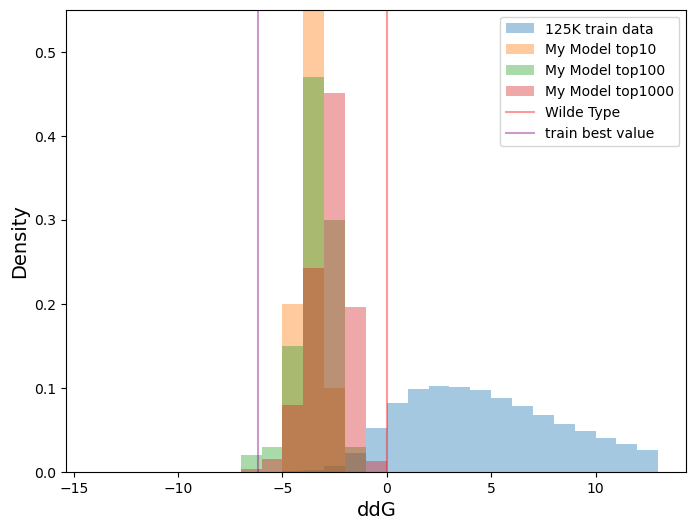

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(train_data.ddG, density=True, label='125K train data', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:10], density=True, label='My Model top10', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:100], density=True, label='My Model top100', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:1000], density=True, label='My Model top1000', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
# plt.hist(paper_estimates, density=True, label='GENhance top100', bins=[i for i in np.arange(-12, 12, 1)], alpha=0.4)

y_list = np.arange(0, 1, 0.1)
x_list = [0.0]*len(y_list)
plt.plot(x_list, y_list, label='Wilde Type', color='r', alpha=0.4)

y_list = np.arange(0, 1, 0.1)
x_list = [train_best_value]*len(y_list)
plt.plot(x_list, y_list, label='train best value', color='purple', alpha=0.4)

plt.ylim(0, 0.55)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
# plt.title("Top100 Generation Comparison")
plt.legend(loc='upper right')
# plt.savefig('./figures/gen_ddG_dist_topk.png', bbox_inches='tight')
# plt.savefig('./figures/gen_ddG_dist_topk.pdf', bbox_inches='tight')

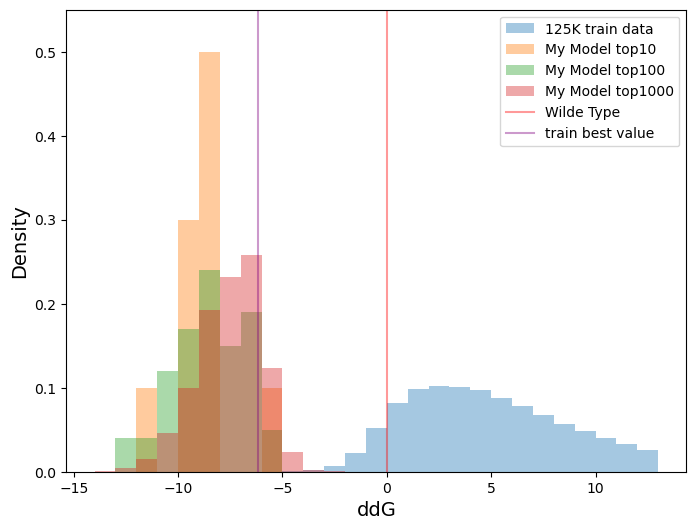

In [46]:
plt.figure(figsize=(8, 6))
plt.hist(train_data.ddG, density=True, label='125K train data', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:10], density=True, label='My Model top10', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:100], density=True, label='My Model top100', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:1000], density=True, label='My Model top1000', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
# plt.hist(paper_estimates, density=True, label='GENhance top100', bins=[i for i in np.arange(-12, 12, 1)], alpha=0.4)

y_list = np.arange(0, 1, 0.1)
x_list = [0.0]*len(y_list)
plt.plot(x_list, y_list, label='Wilde Type', color='r', alpha=0.4)

y_list = np.arange(0, 1, 0.1)
x_list = [train_best_value]*len(y_list)
plt.plot(x_list, y_list, label='train best value', color='purple', alpha=0.4)

plt.ylim(0, 0.55)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
# plt.title("Top100 Generation Comparison")
plt.legend(loc='upper right')
# plt.savefig('./figures/gen_ddG_dist_topk.png', bbox_inches='tight')
# plt.savefig('./figures/gen_ddG_dist_topk.pdf', bbox_inches='tight')

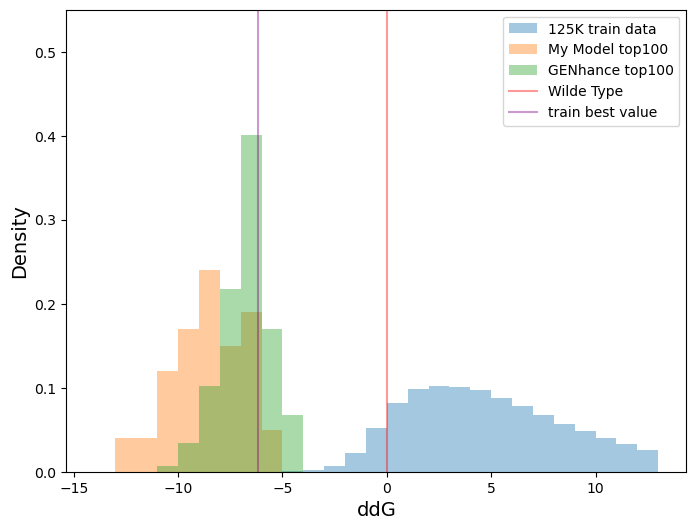

In [45]:
plt.figure(figsize=(8, 6))
plt.hist(train_data.ddG, density=True, label='125K train data', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
# plt.hist(avg_ddG_list[:10], density=True, label='My Model top10', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(avg_ddG_list[:100], density=True, label='My Model top100', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
# plt.hist(avg_ddG_list[:1000], density=True, label='My Model top1000', bins=[i for i in np.arange(-14, 14, 1)], alpha=0.4)
plt.hist(paper_estimates, density=True, label='GENhance top100', bins=[i for i in np.arange(-12, 12, 1)], alpha=0.4)

y_list = np.arange(0, 1, 0.1)
x_list = [0.0]*len(y_list)
plt.plot(x_list, y_list, label='Wilde Type', color='r', alpha=0.4)

y_list = np.arange(0, 1, 0.1)
x_list = [train_best_value]*len(y_list)
plt.plot(x_list, y_list, label='train best value', color='purple', alpha=0.4)

plt.ylim(0, 0.55)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
# plt.title("Top100 Generation Comparison")
plt.legend(loc='upper right')
plt.savefig('./figures/gen_ddG_dist_top100_comp.png', bbox_inches='tight')
plt.savefig('./figures/gen_ddG_dist_top100_comp.pdf', bbox_inches='tight')

In [63]:
%%time
WT_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
hamming_dist_list = [hamming_distance(seq, WT_seq) for seq in gen_seqs]
gen_train_hamming_dist_list = [hamming_distance(row['MT_seq'], WT_seq) for index, row in train_data.iterrows()]

print(f"Hamming distance stats {len(gen_seqs)}")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))
print("std: ", np.std(hamming_dist_list))
len(gen_train_hamming_dist_list)

Hamming distance stats 1000
max:  8
min:  3
median:  6.0
mean:  5.856
std:  1.3027908504437693
CPU times: user 7.95 s, sys: 67.6 ms, total: 8.02 s
Wall time: 8.04 s


250000

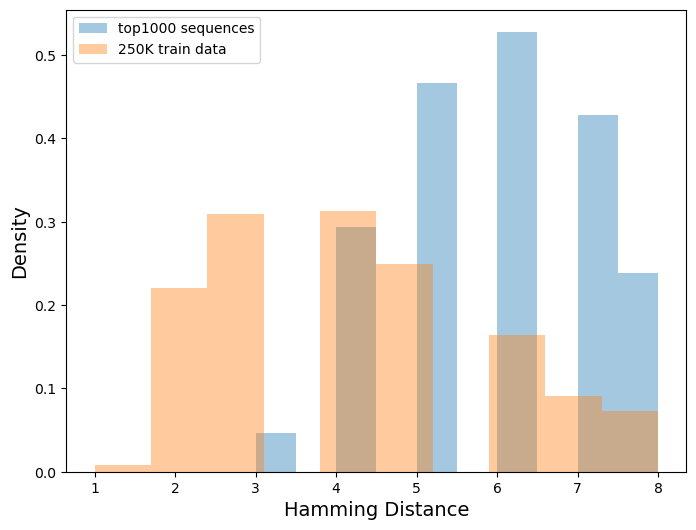

In [67]:
plt.figure(figsize=(8, 6))
# plt.hist(hamming_dist_list, density=True, label='top1000 sequences', bins=[i for i in range(20)], alpha=0.4)
# plt.hist(gen_train_hamming_dist_list, density=True, label='125K train data', bins=[i for i in range(20)], alpha=0.4)
plt.hist(hamming_dist_list, density=True, label='top1000 sequences', alpha=0.4)
plt.hist(gen_train_hamming_dist_list, density=True, label='250K train data', alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
# plt.title("Hamming Distance Distribution")
plt.legend(loc='upper left')
plt.savefig('./figures/ddG_hamming_dist_top1000.png', bbox_inches='tight')
plt.savefig('./figures/ddG_hamming_dist_top1000.pdf', bbox_inches='tight')

In [85]:
len(topk_avg_ddG_list)

100

In [90]:
# train_best_value = np.min(train_data_ddG)
train_best_value = min(train_data.sort_values(by='ddG', ascending=True)[1:].ddG)
train_mean_value = np.mean(train_data_ddG)


def Mean(topk_avg_ddG_list):
    return 'Mean: {:.2f}'.format(np.mean(topk_avg_ddG_list))

def PCI_best(topk_avg_ddG_list):
    num_improve = (np.array(topk_avg_ddG_list) <= train_best_value).sum()
    PCI = num_improve/len(topk_avg_ddG_list)*100
    return 'PCI-Best: {:.2f}%'.format(PCI)

def PCI_mean(topk_avg_ddG_list):
    num_improve = (np.array(topk_avg_ddG_list) <= train_mean_value).sum()
    PCI = num_improve/len(topk_avg_ddG_list)*100
    return 'PCI-Mean: {:.2f}%'.format(PCI)

def PCI_WT(topk_avg_ddG_list):
    num_improve = (np.array(topk_avg_ddG_list) <= 0).sum()
    PCI = num_improve/len(topk_avg_ddG_list)*100
    return 'PCI-WT: {:.2f}%'.format(PCI)

train_best_value, train_mean_value

(-6.15326, 5.958470991966364)

In [91]:
'{}, {}, {}, {}, {}'.format(f'top-{len(topk_avg_ddG_list)}:', Mean(topk_avg_ddG_list), PCI_best(topk_avg_ddG_list), PCI_mean(topk_avg_ddG_list), PCI_WT(topk_avg_ddG_list))

'top-10:, Mean: -8.00, PCI-Best: 100.00%, PCI-Mean: 100.00%, PCI-WT: 100.00%'

In [378]:
'{}, {}, {}, {}, {}'.format(f'top-{len(paper_estimates)}:', Mean(paper_estimates), PCI_best(paper_estimates), PCI_mean(paper_estimates), PCI_WT(paper_estimates))

'top-147:, Mean: -7.11, PCI-Best: 76.19%, PCI-Mean: 100.00%, PCI-WT: 100.00%'

In [129]:
# np.save('./congen4_eval_ddG_list.npy', topk_avg_ddG_list)